## Part 1: 2 minutes to cudf.pandas 🚀🐼

Comment this line in or out depending on whether you want to enable `cudf.pandas`:

In [1]:
%load_ext cudf.pandas

In [2]:
import pandas as pd
import numpy as np
import random
import string

In this section, we're running some basic pandas functions with randomly generated data and timing them.

In [3]:
STRINGS = ["".join(random.choices("abcdefg", k=5)) for _ in range(1000)] + [None]    

def make_df(size):
    return pd.DataFrame(
        {
            "id": np.random.randint(low=0, high=100, size=size),
            "x": np.random.rand(size),
            "y": np.random.rand(size),
            "s": random.choices(STRINGS, k=size)
        }
    )

df1 = make_df(10_000_000)
df2 = make_df(10_000)

In [4]:
%%time
df1.groupby("id").mean()

CPU times: user 0 ns, sys: 10.1 ms, total: 10.1 ms
Wall time: 8.08 ms


,x,y
id,,
0,0.500243,0.499719
1,0.499172,0.500250
2,0.499603,0.499918
3,0.500816,0.499664
4,0.498938,0.500139
...,...,...
95,0.498784,0.500343
96,0.499609,0.499909
97,0.500241,0.499186


In [5]:
%%time
df1["s"].str.contains("a")

CPU times: user 178 µs, sys: 7.45 ms, total: 7.62 ms
Wall time: 6.4 ms


0           True
1          False
2           True
3           True
4          False
           ...  
9999995     True
9999996    False
9999997    False
9999998    False
9999999    False
Name: s, Length: 10000000, dtype: bool

In [6]:
%%time
df1.merge(df2, on=["id", "s"], how="left")

CPU times: user 40.9 ms, sys: 68 µs, total: 40.9 ms
Wall time: 43.9 ms


,id,x_x,y_x,s,x_y,y_y
0,1,0.732639,0.883373,cafed,NaN,NaN
1,11,0.875442,0.537357,beege,NaN,NaN
2,20,0.044541,0.362211,dcaba,NaN,NaN
3,99,0.439447,0.159278,cgfca,NaN,NaN
4,52,0.737281,0.585082,dfddc,NaN,NaN
...,...,...,...,...,...,...
10056734,49,0.423008,0.183173,aeebd,NaN,NaN
10056735,96,0.155579,0.143633,efged,NaN,NaN
10056736,4,0.822802,0.385201,fbdbe,NaN,NaN
10056737,34,0.639133,0.543300,gdfcd,NaN,NaN


In [7]:
%%time
df1.count(axis=0)

CPU times: user 1.56 ms, sys: 143 µs, total: 1.7 ms
Wall time: 1.33 ms


id    10000000
x     10000000
y     10000000
s      9990097
dtype: int64

In [8]:
%%time
df1.count(axis=1)

CPU times: user 1.43 s, sys: 156 ms, total: 1.58 s
Wall time: 1.58 s


0          4
1          4
2          4
3          4
4          4
          ..
9999995    4
9999996    4
9999997    4
9999998    4
9999999    4
Length: 10000000, dtype: int64

### How does this work?

When we did `%load_ext cudf.pandas`, we made it so that `import pandas` (or any submodules) imports a proxy module:

In [9]:
pd

<module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>

That proxy module is composed of proxy functions, and proxy types containing proxy methods:

In [10]:
print(type(pd.read_csv))
print(type(pd.DataFrame))
print(type(pd.DataFrame.max))

<class 'cudf.pandas.fast_slow_proxy._FunctionProxy'>
<class 'cudf.pandas.fast_slow_proxy._FastSlowProxyMeta'>
<class 'cudf.pandas.fast_slow_proxy._MethodProxy'>


Operations on proxy functions and methods dispatch to cuDF or pandas:

<img src="how-cudf-pandas-works.png" width="700">

### Why `.count(axis=1)` is slower when `cudf.pandas` is enabled?

As you can see from the diagram above, when an operation isn't supported by cuDF, we copy data from GPU to CPU and then use pandas for that operation. This copying can add signficant overhead (especially if the data is large).

### Can we use `cudf.pandas` with other libraries?

When `cudf.pandas` enabled, you can still pass DataFrames to other libraries and expect things to work:

<Axes: xlabel='x', ylabel='y'>

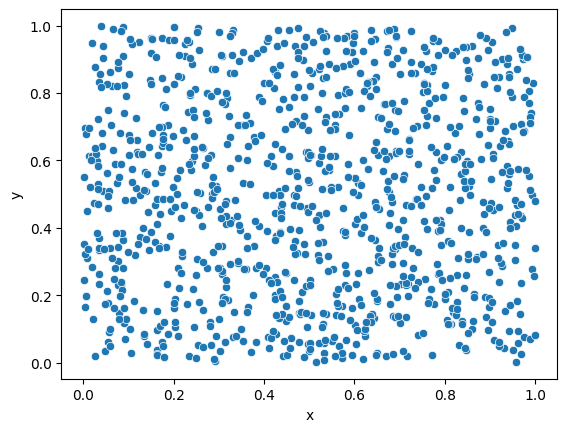

In [12]:
import seaborn as sns

sns.scatterplot(x=df2.x[::10], y=df2.y[::10])

## Part 2: Understanding Performance

Let's generate some data and do some timeseries operations with it:

In [13]:
%%time

rng = pd.date_range("2023-01-01", "2023-02-01", freq="10ms")
data = pd.DataFrame(
    {
        "a": np.random.rand(len(rng)),
        "b": np.random.rand(len(rng))
    },
    index=rng
)
data = data.iloc[rng.indexer_between_time("09:30", "16:00")]
results = data.groupby(pd.Grouper(freq="1D")).mean()
results.head()

CPU times: user 10.7 s, sys: 2.71 s, total: 13.4 s
Wall time: 13.4 s


,a,b
2023-01-01,0.500210,0.500138
2023-01-02,0.500061,0.500137
2023-01-03,0.499990,0.500389
2023-01-04,0.499686,0.500186
2023-01-05,0.499781,0.499800


That runs quite slowly, even when `cudf.pandas` is enabled. Notice what happens when you run the same code with the `%%cudf.pandas.profile` magic: 

### Using the profiler

In [14]:
%%cudf.pandas.profile

rng = pd.date_range("2023-01-01", "2023-02-01", freq="10ms")
data = pd.DataFrame(
    {
        "a": np.random.rand(len(rng)),
        "b": np.random.rand(len(rng))
    },
    index=rng
)
data = data.iloc[rng.indexer_between_time("09:30", "16:00")]
results = data.groupby(pd.Grouper(freq="1D")).mean()
results.head()

,a,b
2023-01-01,0.499945,0.499957
2023-01-02,0.499848,0.500003
2023-01-03,0.499637,0.499774
2023-01-04,0.499860,0.500344
2023-01-05,0.499925,0.500283


                                                                                                                   
                                            Total time elapsed: 12.476 seconds                                     
                                          11 GPU function calls in 1.344 seconds                                   
                                           1 CPU function calls in 4.041 seconds                                   
                                                                                                                   
                                                           Stats                                                   
                                                                                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                      ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ date_range                    │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__         │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DataFrame                     │ 2          │ 0.877       │ 0.439       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.indexer_betwee… │ 0          │ 0.000       │ 0.000       │ 1          │ 4.041       │ 4.041       │
│ _DataFrameIlocIndexer.__geti… │ 1          │ 0.127       │ 0.127       │ 0          │ 0.000       │ 0.000       │
│ Grouper                       │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.groupby             │ 1          │ 0.026       │ 0.026       │ 0          │ 0.000       │ 0.000       │
│ DataFrameResampler.mean       │ 1          │ 0.272       │ 0.272       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.head                │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ DataFrame.__repr__            │ 1          │ 0.030       │ 0.030       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- DatetimeIndex.indexer_between_time

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=992228;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

We get a report that shows what functions executed on the GPU, and what functions executed on the CPU. In the code above, everything executed on the GPU except for the `indexer_between_time` function, which is [not supported by the cuDF library](https://docs.rapids.ai/api/cudf/stable/user_guide/api_docs/). 

### Optimizing our code for GPU execution

The key to getting great performance with `cudf.pandas` is to minimize the number of operations that fall back to CPU. While rarely, this cannot be avoided, it often can be achieved with simple rewrites of your code. Let's rewrite the code to use operations that _are_ supported by cuDF:

In [15]:
%%time

rng = pd.date_range("2023-01-01", "2023-02-01", freq="100ms")
data = pd.DataFrame(
    {
        "a": np.random.rand(len(rng)),
        "b": np.random.rand(len(rng))
    },
    index=rng
)

# note: using datetime properties instead of `indexer_between_time`:
data = data.iloc[((rng.hour >= 9) & (rng.minute >= 30)) | (rng.hour <= 16)]

results = data.groupby(pd.Grouper(freq="1D")).mean()
results.head()

CPU times: user 512 ms, sys: 148 ms, total: 660 ms
Wall time: 668 ms


,a,b
2023-01-01,0.500073,0.500108
2023-01-02,0.500326,0.500323
2023-01-03,0.499953,0.500129
2023-01-04,0.500166,0.499553
2023-01-05,0.500413,0.500279


Not only is this _much_ faster on the GPU, but it's also quite a bit faster on the CPU - a nice win-win!

## Part 3: third-party code acceleration

In this section, we'll demonstrate how `cudf.pandas` works with third-party libraries that depend on pandas.

We'll load some data into a DataFrame and use [langchain's Pandas integration](https://python.langchain.com/docs/integrations/toolkits/pandas) to answer questions about that data. We'll see that even though langchain doesn't know anything about cuDF, it will still automagically use the GPU to answer those questions much faster than with regular pandas!

⚠️ Note that at the time of writing, `langchain` is undergoing considerable changes (for example, see [here](https://github.com/langchain-ai/langchain/discussions/14243)). You may have to change some of the code in this notebook to make it work.

💰❗ Here we're using OpenAI's `gpt-4` model with langchain ([setup instructions](https://python.langchain.com/docs/integrations/llms/openai)). Note that at the time of writing, you need to buy credits from OpenAI to use this model via API.

In [16]:
from langchain.agents.agent_types import AgentType
from langchain.chat_models import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.llms import OpenAI

from langchain.cache import SQLiteCache
from langchain.globals import set_llm_cache
set_llm_cache(SQLiteCache(database_path=".langchain.db"))

### Loading the data

In [17]:
df = pd.concat(
    [
        pd.read_parquet("yellow_tripdata_2021-{:02d}.parquet".format(i))
        for i in range(1, 13)
    ]
)

df = df[["VendorID",
         "tpep_pickup_datetime",
         "tpep_dropoff_datetime",
         "passenger_count",
         "tip_amount"]]

df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,tip_amount
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,0.00
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.00
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,8.65
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,6.05
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.06


### Asking questions about our data

In [18]:
agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-4"),
    df,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    handle_parsing_errors=True,
)

In [19]:
%%time
print(agent.run("How many rows are there?"))

There are 30,904,308 rows in the dataframe.
CPU times: user 1.12 s, sys: 560 ms, total: 1.68 s
Wall time: 1.67 s


In [20]:
%%time
print(agent.run("Which vendor received the most tips?"))

The vendor with the ID 2 received the most tips.
CPU times: user 1.1 s, sys: 482 ms, total: 1.59 s
Wall time: 1.57 s


In [21]:
%%time
print(
    agent.run(
        """
        Which 30-minute, 1-hour, 2-hour, 5-hour and 24-hour windows have the most trips?
        Don't use any inplace operations please!
        """
    )
)

The 30-minute window with the most trips is from 18:30 to 19:00 on 2021-12-03.

The 1-hour window with the most trips is from 18:00 to 19:00 on 2021-12-03.

The 2-hour window with the most trips is from 18:00 to 20:00 on 2021-11-19.

The 5-hour window with the most trips is from 17:00 to 22:00 on 2021-12-03.

The 24-hour window with the most trips is from 00:00 to 23:59 on 2021-12-03.
CPU times: user 1.53 s, sys: 648 ms, total: 2.18 s
Wall time: 2.21 s
